### Super Resolution Generative Adversarial Networks (SRGAN)
[original paper](https://arxiv.org/abs/1609.04802) <br>

#### Datasets:
[Div2k](https://data.vision.ee.ethz.ch/cvl/DIV2K/)

In [3]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# configure the GPU
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
hr_shape = (None, None, 3)

In [3]:
def load_vgg(hr_shape):
    vgg = keras.applications.VGG19(include_top=False, weights="imagenet", input_shape=hr_shape)
    # vgg.load_weights('./models/VGG19/weights.h5')
    vgg.trainable = False
    return keras.Model(inputs=vgg.input, outputs=vgg.layers[10].output, name='vgg')

![why percetual loss?](./images/why_plos.png)

## Generator Network
![Generator Network](./images/SRGEN.png)

### k(kernel-size)n(num-filters)s(stride)

In [4]:
# B residual block
def res_block(_input):
    # k3n64s1
    res_model = layers.Conv2D(64, (3, 3), padding='same')(_input)
    res_model = layers.BatchNormalization(momentum=0.5)(res_model)
    res_model = layers.PReLU(shared_axes=[1,2])(res_model)

    # k3n64s1
    res_model = layers.Conv2D(64, (3, 3), padding='same')(res_model)
    res_model = layers.BatchNormalization(momentum=0.5)(res_model)

    return layers.add([_input, res_model])

def upscale_block(_input):
    # k3n256s1
    up_model = layers.Conv2D(256, (3, 3), padding='same')(_input)
    up_model = layers.UpSampling2D(size=2)(up_model)
    up_model = layers.PReLU(shared_axes=[1,2])(up_model)

    return up_model

def create_generator(_input, num_residual_blocks=16):

    # Initial Convolution

    # k9n64s1
    gen_model = layers.Conv2D(64, (9, 9), padding='same')(_input)
    gen_model = layers.PReLU(shared_axes=[1,2])(gen_model)

    temp = gen_model

    # Residual Blocks
    for i in range(num_residual_blocks):
        gen_model = res_block(gen_model)

    # Post Residual Blocks
    
    # k3n64s1
    gen_model = layers.Conv2D(64, (3, 3), padding='same')(gen_model)
    gen_model = layers.BatchNormalization(momentum=0.5)(gen_model)
    gen_model = layers.add([gen_model, temp])

    # Upsampling

    gen_model = upscale_block(gen_model)
    gen_model = upscale_block(gen_model)

    # Output

    # k9n3s1
    output = layers.Conv2D(3, (9, 9), padding='same')(gen_model)

    return keras.Model(inputs=_input, outputs=output, name='generator')

![B = 16](./images/b=16.png)

## Discriminator Network
![Discriminator Network](./images/SRDIS.png)

In [5]:
def discriminator_block(_input, filters, strides=1, bn=True):
    d_model = layers.Conv2D(filters, (3, 3), strides=strides, padding='same')(_input)
    if bn:
        d_model = layers.BatchNormalization(momentum=0.8)(d_model)
    d_model = layers.LeakyReLU(alpha=0.2)(d_model)
    return d_model

def discriminator(_input):
    # k3n64s1
    d_model = discriminator_block(_input, 64, bn=False)
    # k3n64s2
    d_model = discriminator_block(d_model, 64, strides=2)
    # k3n128s1
    d_model = discriminator_block(d_model, 128)
    # k3n128s2
    d_model = discriminator_block(d_model, 128, strides=2)
    # k3n256s1
    d_model = discriminator_block(d_model, 256)
    # k3n256s2
    d_model = discriminator_block(d_model, 256, strides=2)
    # k3n512s1
    d_model = discriminator_block(d_model, 512)
    # k3n512s2
    d_model = discriminator_block(d_model, 512, strides=2)

    d_model = layers.Flatten()(d_model)
    d_model = layers.Dense(1024)(d_model)
    d_model = layers.LeakyReLU(alpha=0.2)(d_model)
    output = layers.Dense(1, activation="sigmoid")(d_model)
    
    return keras.Model(inputs=_input, outputs=output, name='discriminator')

In [4]:
lr_dim = 64
hr_dim = 256
epochs = 100
scale_factor = hr_dim // lr_dim
batch_size = 1

In [29]:
hr_dataset = lr_dataset = keras.preprocessing.image_dataset_from_directory(
    directory="./dataset/DIV2K_train_HR",
    labels=None,
    image_size=(hr_dim, hr_dim),
    batch_size=batch_size,
    shuffle=True,
    color_mode="rgb",
).map(lambda x: x/255)

Found 800 files belonging to 1 classes.


In [36]:
items = hr_dataset.take(800)

## Loss functions

## Perceptual loss function
![Perceptual loss function](./images/perceptual_loss.jpg)

## Content Loss (Mean Squared Error)
![Content loss function](./images/content_loss_SRGAN.jpg)

## Adversarial loss function (Binary Cross Entropy)
![Adversarial loss function](./images/adversarial_loss_SRGAN.jpg)

In [8]:
class SRGAN(keras.Model):
    def __init__(self, discriminator, generator, vgg):
        super(SRGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.vgg = vgg

    def compile(self, loss_mse, loss_bce, opt_dis, opt_gen):
        super(SRGAN, self).compile()
        self.loss_mse = loss_mse
        self.loss_bce = loss_bce
        self.opt_dis = opt_dis
        self.opt_gen = opt_gen
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        self.p_loss_metric = keras.metrics.Mean(name="p_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def downscale(self, x, factor=2):
        return tf.image.resize(x, (x.shape[1] // factor, x.shape[2] // factor), method="area")

    def train_step(self, hr_img):
        lr_img = self.downscale(hr_img, scale_factor)

        batch_size = tf.shape(hr_img)[0]
        fake_labels = tf.zeros((batch_size, 1))
        real_labels = tf.ones((batch_size, 1))
        
        # add noise to labels 
        labels = tf.concat([fake_labels, real_labels], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
            fake_images = self.generator(lr_img)
            
            # train discriminator
            self.discriminator.trainable = True
            d_hr_out = self.discriminator(hr_img)
            d_fake_out = self.discriminator(fake_images)

            dis_output = tf.concat([d_hr_out, d_fake_out], axis=0)

            d_loss = self.loss_bce(dis_output, labels)
            # sum all values in d_loss  
            d_loss = tf.reduce_sum(d_loss)
            
            # adversarial loss
            adv_loss = self.loss_bce(tf.ones_like(d_fake_out), d_fake_out)

            # content loss
            gen_features = self.vgg(fake_images)/12.75
            hr_features = self.vgg(hr_img)/12.75

            content_loss = self.loss_mse(hr_features, gen_features)

            # total loss (perceptual loss function = content loss + adversarial loss)
            total_loss = content_loss + (1e-3 * adv_loss)

        gradients_gen = gen_tape.gradient(total_loss, self.generator.trainable_variables)
        gradients_dis = dis_tape.gradient(d_loss, self.discriminator.trainable_variables)

        self.opt_gen.apply_gradients(zip(gradients_gen, self.generator.trainable_variables))
        self.opt_dis.apply_gradients(zip(gradients_dis, self.discriminator.trainable_variables))

        # Update metrics
        self.d_loss_metric(d_loss)
        self.g_loss_metric(total_loss)
        self.p_loss_metric(content_loss)

        return {
            "d_loss": d_loss,
            "g_loss": total_loss,
            "p_loss": content_loss
        }

In [9]:
# for starting training from scratch
start_at = 0
vgg_model = load_vgg((None, None, 3))
generator_model = create_generator(layers.Input(shape=(lr_dim, lr_dim, 3)))
discriminator_model = discriminator(layers.Input(shape=(hr_dim, hr_dim, 3)))

In [ ]:
# for starting training from a start point
start_at = 0 ## chaange this number
vgg_model = load_vgg((None, None, 3))
generator_model = keras.models.load_model(f"./models/SRGAN/gen/generator-{start_at}")
discriminator_model = keras.models.load_model(f"./models/SRGAN/dis/discriminator-{start_at}")

In [5]:
from PIL import Image
def load_image(im_path):
    im = Image.open(im_path)
    im_dims =  im.size

    # find the next values for x, y such that they are divisible by 64

    x = im_dims[0]
    y = im_dims[1]

    if x % 64 != 0:
        x += 64 - (x % 64)
    if y % 64 != 0:
        y += 64 - (y % 64)

    im = im.resize((x, y))
    im_dims =  im.size
    dim_ratio = im_dims[0] / im_dims[1]
    # im = im.resize((lr_dim, lr_dim))
    im = np.array(im).astype(np.float32)
    im = im[:, :, :3]
    return np.expand_dims((im / 255), axis=0), dim_ratio

In [6]:
def load_image_lr(path):
    im = Image.open(path)
    im_dims =  im.size

    # load the image in lr_dim, lr_dim
    im = im.resize((lr_dim, lr_dim))
    im = np.array(im).astype(np.float32)
    im = im[:, :, :3]
    return np.expand_dims((im / 255), axis=0)

In [7]:
def downscale(x, factor=2):
    return tf.image.resize(x, (x.shape[1] // factor, x.shape[2] // factor), method="area")

In [12]:
class SRGAN_Callback(keras.callbacks.Callback):
    def __init__(self, image_path="./images/SRTEST.png"):
        super(SRGAN_Callback, self).__init__()
        self.test_file_path = image_path

    def on_epoch_end(self, epoch, logs=None):

        if epoch%10 == 0:
            self.model.generator.save(f"./models/SRGAN/gen/generator-{start_at+epoch+1}")
            self.model.discriminator.save(f"./models/SRGAN/dis/discriminator-{start_at+epoch+1}")


In [13]:
model = SRGAN(discriminator_model, generator_model, vgg_model)
model.compile(
    loss_mse=keras.losses.MeanSquaredError(),
    loss_bce=keras.losses.BinaryCrossentropy(),
    opt_dis=keras.optimizers.Adam(1e-4, beta_1=0.9, beta_2=0.999),
    opt_gen=keras.optimizers.Adam(1e-4, beta_1=0.9, beta_2=0.999)
)

In [14]:
history = model.fit(
    hr_dataset, 
    epochs=epochs,
    callbacks=[SRGAN_Callback()],
    )

Epoch 1/100
800/800 [==============================] - ETA: 0s - d_loss: 1.5960 - g_loss: 0.3336 - p_loss: 0.4889- ETA: 3s - d_loss: 1.4987 - g_loss: 0.2334  - ETA: 1s - d_loss: 1.7727 - g_loss: 0.1960 - p_loss: 0 - ETA: 1s - d_loss: 1.6577 - g_loss: 0.3854 - p_WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
INFO:tensorflow:Assets written to: ./models/SRGAN/gen/generator-1\assets


C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: ./models/SRGAN/dis/discriminator-1\assets
800/800 [==============================] - 135s 150ms/step - d_loss: 1.5960 - g_loss: 0.3336 - p_loss: 0.4888
Epoch 2/100
145/800 [====>.........................] - ETA: 1:09 - d_loss: 2.4612 - g_loss: 0.4359 - p_loss: 0.3497

In [27]:
model = keras.models.load_model(f"./models/SRGAN/gen/generator-320")

KeyboardInterrupt: 

In [8]:
# file_path = "./images/vedant.jpg"
# file_path = "./images/burger.jpg"
file_path = "./images/number_plate_lr.png"
# file_path = "./images/number_plate.png"

_image, dim_ratio = load_image(file_path)

In [9]:
lr_image = load_image_lr(file_path)

numpy.ndarray

In [22]:
lr_image.shape

(1, 64, 64, 3)

In [7]:
dim_ratio

1.0

In [63]:
# enlarge the image to the dim_ratio
def unpack(img, dim_ratio):
    img = img * 255
    img = img.astype(np.uint8)
    img = Image.fromarray(img)
    img = img.resize((int(img.size[0] * dim_ratio), int(img.size[1])))
    return img

# enlarges the image in the given axis to the dim_ratio
def unpack_in_axis(img, dim_ratio, axis):
    img = img * 255
    img = img.astype(np.uint8)
    img = Image.fromarray(img)

    if axis == 1:
        img = img.resize((int(img.size[0] * dim_ratio), int(img.size[1])))

    if axis == 0:
        img = img.resize((int(img.size[0]), int(img.size[1] * dim_ratio)))
        
    return np.array(img, dtype=np.float32)/255


# squeezes the image such that both dimensions are divisible by 64
def pack(img):
    pack_axis = np.argmin(img.shape[:-1])
    lower_dim = img.shape[pack_axis]
    dim_ratio = img.shape[0] / img.shape[1]
    # resize image to the lower dimension
    img = img * 255
    img = img.astype(np.uint8)
    img = Image.fromarray(img)
    img = img.resize((int(lower_dim), int(lower_dim)))  
    img = np.array(img)
    img = img.astype(np.float32)

    return img/255, dim_ratio, pack_axis
    

In [13]:
pack(_image[0])

(array([[[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [0.99215686, 1.        , 0.99215686],
         [0.99215686, 1.        , 0.99215686],
         [0.99215686, 1.        , 0.99215686]],
 
        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [0.99215686, 1.        , 0.99215686],
         [0.99215686, 1.        , 0.99215686],
         [0.99215686, 1.        , 0.99215686]],
 
        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [0.99215686, 1.        , 0.99215686],
         [0.99215686, 1.        , 0.99215686],
         [0.99215686, 1.        , 0.99215686]],
 
        ...,
 
        [[0.8627451 , 0.8784314 , 0.88235295],
         [0.85490197, 0.8745098 , 0.87843

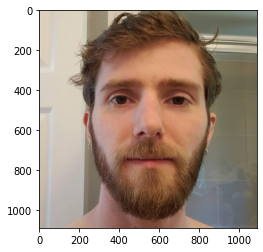

In [9]:
plt.imshow(unpack(_image[0], dim_ratio))

In [10]:
_image.shape

(1, 1088, 1088, 3)

In [13]:
def convolute(img, model):
    upscaled = []

    for x in range(0, img.shape[0], 64):
        for y in range(0, img.shape[1], 64):
            temp = np.expand_dims(img[x:x+64, y:y+64, :], axis=0)
            # temp = model(np.array(img[x:x+64, y:y+64, :]))
            temp = model(temp)
            upscaled.append(temp)

    return upscaled

In [17]:
packed_image, dim_ratio, pack_axis = pack(_image[0])

In [18]:
packed_image.shape

(1088, 1088, 3)

In [19]:
upscaled_windows = convolute(packed_image, model)

In [20]:
len(upscaled_windows)

289

In [21]:
upscaled_windows[0].shape

TensorShape([1, 256, 256, 3])

In [10]:
# stitch the windows into one image
def stitch(windows, dims=None):
    # create empty image of the right size
    img = np.zeros(dims)
    
    # loop through windows and add them to the image
    x, y = 0, 0
    for i in range(len(windows)):
        # print(i)
        img[x:x+256, y:y+256, :] = windows[i][0]
        y += 256
        if y >= dims[0]:
            y = 0
            x += 256  

    return img

In [23]:
packed_image.shape

(1088, 1088, 3)

In [24]:
packed_image.shape[0] * scale_factor, packed_image.shape[1] * scale_factor

(4352, 4352)

In [25]:
upscaled = stitch(upscaled_windows, (packed_image.shape[0] * scale_factor, packed_image.shape[1] * scale_factor, 3))

In [26]:
upscaled.shape

(4352, 4352, 3)

In [27]:
len(upscaled_windows)

289

In [11]:
def upscale_convolute(img, model):
    packed_image, dim_ratio, axis = pack(img[0])

    upscaled_windows = convolute(packed_image, model)

    upscaled = stitch(upscaled_windows, (packed_image.shape[0] * scale_factor, packed_image.shape[1] * scale_factor, 3))

    return unpack_in_axis(upscaled, dim_ratio, axis), upscaled
    # return upscaled

In [56]:
upscaled_original, upscaled_square = upscale_convolute(_image, model)

In [15]:
def save_image(img, path):
    # clip image between 0, 1
    img = np.clip(img, 0, 1)
    img = img * 255
    img = img.astype(np.uint8)
    img = Image.fromarray(img)
    img.save(path)

In [57]:
save_image(upscaled_square, "./upscaled/ai_upscaled.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


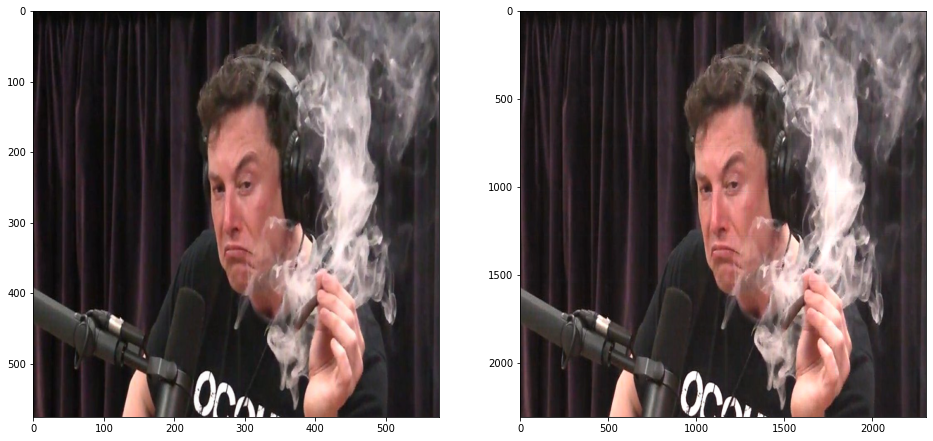

In [68]:
plt.subplot(1, 2, 1)
plt.imshow(pack(_image[0])[0])
plt.subplot(1, 2, 2)
plt.imshow(upscaled_square)
plt.show()

In [58]:
save_image(traditional_upscale_numpy(pack(_image[0])[0], scale_factor), "./upscaled/traditional_upscaled.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


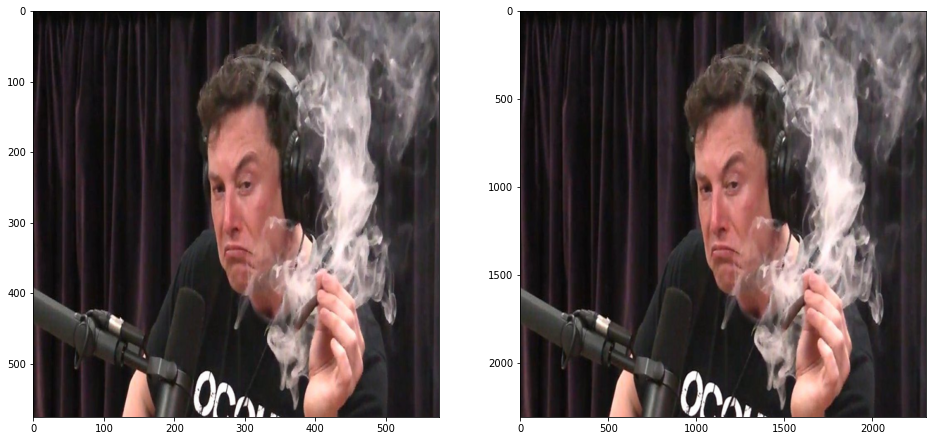

In [73]:
plt.subplot(1, 2, 1)
plt.imshow(pack(_image[0])[0])
plt.subplot(1, 2, 2)
plt.imshow(traditional_upscale_numpy(pack(_image[0])[0], scale_factor))
plt.show()

In [17]:
def upscale(img):
    _output = model(img)[0]

    # clip values between 0 and 1
    _output = np.clip(_output, 0, 1)

    return _output

In [30]:
import cv2

def traditional_upscale_numpy(img, scale_factor):
    _output = img
    _output = cv2.resize(_output, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
    return _output

def traditional_upscale(img_path, method=cv2.INTER_NEAREST):
    img = cv2.imread(img_path)
    # BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (lr_dim, lr_dim))
    img = cv2.resize(img, (hr_dim, hr_dim), interpolation=method)
    # return as numpy
    
    return img/255

In [31]:
# resize the plt plot to 16, 16
plt.rcParams['figure.figsize'] = (16, 16)

In [49]:
lr_to_hr_ai = upscale(lr_image)
lr_to_hr_trad = traditional_upscale(file_path, method=cv2.INTER_CUBIC)

In [50]:
save_image(lr_to_hr_ai, "./upscaled/ai_upscaled_64_256.png")
save_image(lr_to_hr_trad, "./upscaled/traditional_upscaled_64_256.png")

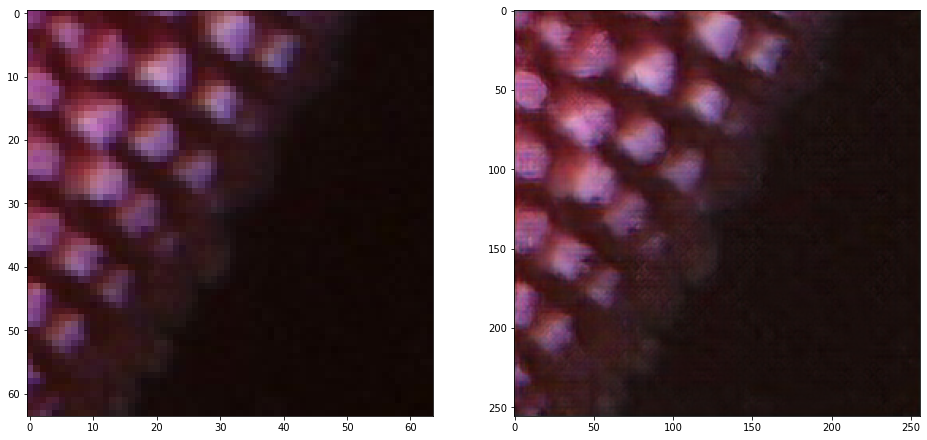

In [67]:
hr = upscale(np.expand_dims(windows[499], axis=0))
# hr = unpack(hr, dim_ratio)
temp = unpack(test[0], dim_ratio)
plt.subplot(1, 2, 1)
plt.imshow(windows[499])
plt.subplot(1, 2, 2)
plt.imshow(hr)
plt.show()

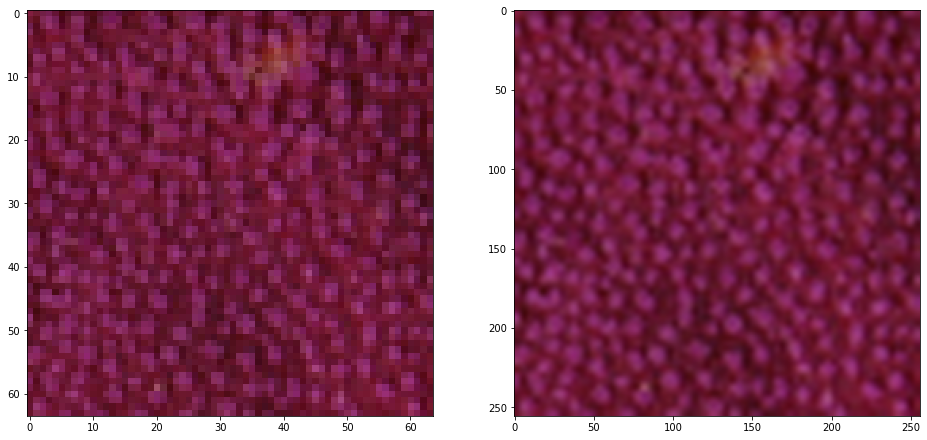

In [15]:
t_hr = traditional_upscale(file_path)
t_hr = unpack(t_hr, dim_ratio)
plt.subplot(1, 2, 1)
plt.imshow(temp)
plt.subplot(1, 2, 2)
plt.imshow(t_hr)
plt.show()

In [1]:
from generator_models import *
from generator_models import load_image as load_image_2

C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
srgan = SRGAN("./models/SRGAN/gen/generator-320")

In [3]:
dcgan = DCGAN("./models/DCGAN/gen_128x128/generator_314")

In [5]:
dcgan.generate()

In [6]:
srgan.upscale_64_256("./images/burger.png")

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [50]:
test = load_image_2(file_path, shape=None)

In [52]:
img, ratio, axis = srgan.pack(test[0])
img = srgan.downscale(img, (lr_dim, lr_dim))
img = np.expand_dims(img, axis=0)

In [54]:
output = srgan.model(img).numpy()

In [56]:
output = np.clip(output, 0, 1)

In [66]:
_final = unpack_in_axis(output[0], ratio, axis)

In [67]:
_final = tf.image.convert_image_dtype(_final, tf.uint8)
_final = tf.image.encode_png(_final)

In [68]:
tf.io.write_file("./upscaled/srgan_upscaled.png", _final)